In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import chainer
 
start = dt.date(2016,1,1)
end = dt.date(2018,3,30)
df= web.DataReader('AMZN',"morningstar",start,end)

df.head(10)

Close     High       Low    Open   Volume
Symbol Date                                                  
AMZN   2016-01-01  675.89  675.890  675.8900  675.89        0
       2016-01-04  636.99  657.715  627.5100  656.29  9314519
       2016-01-05  633.79  646.910  627.6500  646.86  5822603
       2016-01-06  632.65  639.790  620.3100  622.00  5329197
       2016-01-07  607.94  630.000  605.2100  621.80  7074915
       2016-01-08  607.05  624.140  606.0000  619.66  5512915
       2016-01-11  617.74  619.850  598.5700  612.48  4891551
       2016-01-12  617.89  625.990  612.2415  625.25  4724100
       2016-01-13  581.81  620.880  579.1600  620.88  7655239
       2016-01-14  593.00  602.250  569.8800  580.25  7237978

In [2]:
from sklearn.preprocessing import MinMaxScaler
 
#株価の標準化
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(df['Close'])
 
#訓練データと教師データへの分割
 
x,t = [],[]
 
N = len(df)

M = 25
for n in range(M,N):
    _x = df['Close'][n-M:n]
    _t = df['Close'][n]
    x.append(_x)
    t.append(_t)

#例：x[1]は初日から25日分の(標準化された)Closeﾃﾞｰﾀ
x = np.array(x, dtype = np.float32)
t = np.array(t, dtype = np.float32).reshape(len(t),1)

# 訓練：70%, 検証：30%で分割する
n_train = int(len(x) * 0.7)
dataset = list(zip(x, t))
train, test = chainer.datasets.split_dataset(dataset,n_train)

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [3]:
# chainerと必要なパッケージをインポート
import chainer.links as L
import chainer.functions as F
from chainer import Chain, Variable, datasets, optimizers
from chainer import report, training
from chainer.training import extensions
import chainer.cuda

# ニューラルネットワークモデルを作成
class RNN(Chain):
    def __init__(self, n_units, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, n_units)
            self.l2 = L.Linear(None, n_output)
        
    def reset_state(self):
        self.l1.reset_state()

        
    def __call__(self, x, t):
        y = self.predict(x)
        loss = F.mean_squared_error(y, t)
        report({'loss':loss},self)
        return loss
        
    def predict(self, x):
        if train:
            h1 = F.dropout(self.l1(x),ratio = 0.5)
        else:
            h1 = self.l1(x)
        return self.l2(h1)

## LSTMUpdaterを作る。
class LSTMUpdater(training.StandardUpdater):
    def __init__(self, data_iter, optimizer, device=None):
        super(LSTMUpdater,self).__init__(data_iter, optimizer, device=None)
        self.device = device
        
    def update_core(self):
        data_iter = self.get_iterator("main")
        optimizer = self.get_optimizer("main")
        
        batch = data_iter.__next__()
        x_batch, t_batch = chainer.dataset.concat_examples(batch, self.device)
        
        optimizer.target.reset_state()           #追加
        optimizer.target.cleargrads()
        loss = optimizer.target(x_batch, t_batch)
        loss.backward()
        loss.unchain_backward()                  #追記
        optimizer.update() 

In [4]:
# 乱数のシードを固定 (再現性の確保)
np.random.seed(1)
 
# モデルの宣言
model = RNN(30, 1)
 
# GPU対応
#chainer.cuda.get_device(0).use()
#model.to_gpu()                 
 
# Optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)
 
# Iterator
batchsize = 20 #ﾐﾆﾊﾞｯﾁのｻｲｽﾞ
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
 
# Updater &lt;- LSTM用にカスタマイズ
updater = LSTMUpdater(train_iter, optimizer,device = -1)
 
# Trainerとそのextensions
epoch = 3000
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')
 
# 評価データで評価
trainer.extend(extensions.Evaluator(test_iter, model,device = -1))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
 
# １エポックごとに、trainデータに対するlossと、testデータに対するlossを出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

In [5]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           0.0177163   0.200486              0.0525276     
2           0.00752011  0.168069              0.108975      
3           0.00694324  0.173506              0.164825      
4           0.00543045  0.223938              0.219984      
5           0.00442304  0.213056              0.280717      
6           0.00408179  0.27247               0.337397      
7           0.00451351  0.241367              0.394331      
8           0.00365032  0.276942              0.44926       
9           0.00371287  0.284295              0.508785      
10          0.00334407  0.286934              0.570223      
11          0.00348491  0.270094              0.62743       
12          0.00284434  0.298069              0.683885      
13          0.00295182  0.286592              0.742858      
14          0.00295216  0.246592              0.80161       
15          0.00305381  0.299721              0.856172      
16          0.00322425  0.

134         0.000691772  0.197849              8.93366       
135         0.000646274  0.200539              9.00647       
136         0.00070863  0.207758              9.07304       
137         0.000690651  0.184619              9.14238       
138         0.000835052  0.204878              9.21507       
139         0.000584592  0.202099              9.28402       
140         0.000613846  0.212484              9.34901       
141         0.000730928  0.206609              9.41812       
142         0.000691601  0.214796              9.49053       
143         0.000680575  0.173406              9.55481       
144         0.000736089  0.162686              9.62129       
145         0.000870834  0.221925              9.6942        
146         0.000648536  0.233882              9.76147       
147         0.000666214  0.199178              9.82809       
148         0.000848633  0.175845              9.89764       
149         0.000784932  0.190318              9.96814       
150      

269         0.000528432  0.194643              19.0359       
270         0.000600798  0.147768              19.113        
271         0.000711284  0.177258              19.1845       
272         0.000585142  0.15558               19.2668       
273         0.000607275  0.171095              19.3412       
274         0.000598799  0.173175              19.4161       
275         0.000549675  0.161443              19.4853       
276         0.000739921  0.129371              19.5593       
277         0.000575877  0.139661              19.6331       
278         0.000702353  0.12895               19.7042       
279         0.000693972  0.151879              19.7807       
280         0.000522201  0.1271                19.8504       
281         0.000690131  0.156429              19.9201       
282         0.000731758  0.154973              19.9945       
283         0.000750749  0.156753              20.0676       
284         0.00052549  0.157717              20.1387       
285      

403         0.000568328  0.173487              29.5908       
404         0.000601415  0.164644              29.6777       
405         0.00060897  0.16604               29.7509       
406         0.000539865  0.129519              29.8265       
407         0.000604905  0.124398              29.9117       
408         0.000629106  0.117412              29.9859       
409         0.000689883  0.15741               30.0713       
410         0.000508398  0.157375              30.1453       
411         0.000581471  0.157759              30.2203       
412         0.000651407  0.141572              30.3045       
413         0.000640737  0.180461              30.3798       
414         0.000641429  0.136293              30.4605       
415         0.000572685  0.137888              30.5508       
416         0.000562899  0.159321              30.631        
417         0.000554603  0.126824              30.7047       
418         0.000607873  0.121761              30.7811       
419      

536         0.000619982  0.104431              40.6197       
537         0.000662054  0.125195              40.7053       
538         0.000597096  0.127088              40.7878       
539         0.000646528  0.12152               40.8766       
540         0.000682989  0.10405               40.9542       
541         0.000706312  0.109362              41.0337       
542         0.000554275  0.121945              41.1117       
543         0.000628928  0.115828              41.192        
544         0.000504986  0.154853              41.269        
545         0.00055275  0.126533              41.3479       
546         0.000574207  0.11007               41.4332       
547         0.000584537  0.126122              41.614        
548         0.000637174  0.130817              41.6937       
549         0.000661125  0.0893798             41.7708       
550         0.000601614  0.108785              41.8601       
551         0.000534314  0.110047              41.9464       
552      

670         0.000616308  0.118249              52.4907       
671         0.000648692  0.119047              52.5787       
672         0.000594527  0.110186              52.6633       
673         0.000458915  0.098604              52.7503       
674         0.000631546  0.0976857             52.8329       
675         0.000578826  0.0930688             52.9211       
676         0.000590438  0.146791              53.0062       
677         0.000628659  0.122227              53.0995       
678         0.000576798  0.105782              53.1808       
679         0.000549148  0.12919               53.2651       
680         0.000554906  0.0856429             53.3539       
681         0.000628827  0.125045              53.4436       
682         0.000530069  0.135166              53.5323       
683         0.000539133  0.121053              53.6135       
684         0.000555885  0.1227                53.698        
685         0.000599752  0.13915               53.784        
686     

805         0.000708431  0.112529              64.9706       
806         0.000577927  0.104109              65.0678       
807         0.000637672  0.0929045             65.1711       
808         0.000544086  0.117008              65.2626       
809         0.000632159  0.120176              65.3586       
810         0.000576089  0.125434              65.4492       
811         0.000541137  0.117892              65.5433       
812         0.000588425  0.113705              65.6312       
813         0.000694115  0.123165              65.7227       
814         0.000632113  0.145237              65.8136       
815         0.000471163  0.116501              65.9048       
816         0.000576058  0.113313              65.9941       
817         0.000567637  0.104324              66.0882       
818         0.000610349  0.0930811             66.1746       
819         0.000539203  0.0881652             66.2758       
820         0.000578455  0.0935629             66.3623       
821     

940         0.000608481  0.105131              78.2627       
941         0.000564008  0.108805              78.356        
942         0.000554358  0.119332              78.4485       
943         0.000581162  0.110161              78.5457       
944         0.000558632  0.120198              78.6374       
945         0.000596296  0.090933              78.7261       
946         0.000704996  0.0913698             78.8277       
947         0.000533218  0.104033              78.9201       
948         0.000661389  0.0927953             79.0136       
949         0.0006397   0.0821601             79.1231       
950         0.000649807  0.101646              79.2204       
951         0.000643982  0.0950004             79.3198       
952         0.000521869  0.0772637             79.4243       
953         0.000586575  0.104414              79.5144       
954         0.000562203  0.0962936             79.6092       
955         0.000474959  0.102334              79.7013       
956      

1073        0.000726827  0.100383              91.6865       
1074        0.00061029  0.10754               91.7828       
1075        0.00055527  0.102693              91.921        
1076        0.000500616  0.0899148             92.0239       
1077        0.000588743  0.111574              92.1253       
1078        0.0006034   0.0989469             92.2226       
1079        0.00058447  0.0820854             92.3244       
1080        0.00065324  0.0919952             92.4321       
1081        0.000550958  0.0811927             92.529        
1082        0.000576172  0.112916              92.635        
1083        0.000589586  0.0888344             92.7338       
1084        0.000560535  0.0953681             92.8298       
1085        0.000579991  0.118332              92.9293       
1086        0.000595064  0.0951697             93.0311       
1087        0.000592104  0.103714              93.127        
1088        0.000549207  0.100054              93.2284       
1089        0

1207        0.000631415  0.0917969             105.542       
1208        0.000564749  0.0917715             105.648       
1209        0.00056574  0.0866266             105.751       
1210        0.000557796  0.10099               105.861       
1211        0.000621853  0.107246              105.961       
1212        0.000600458  0.0983706             106.07        
1213        0.000617993  0.0861352             106.165       
1214        0.000559909  0.0964761             106.27        
1215        0.000675871  0.102034              106.377       
1216        0.000640002  0.107738              106.486       
1217        0.000622636  0.084244              106.588       
1218        0.000550066  0.0856703             106.688       
1219        0.00048959  0.0709963             106.79        
1220        0.000532124  0.0891249             106.898       
1221        0.000510881  0.0861221             107.005       
1222        0.000539333  0.0779988             107.111       
1223      

1340        0.000658003  0.108575              119.84        
1341        0.000523999  0.087537              119.946       
1342        0.000645943  0.0755884             120.06        
1343        0.000435722  0.0872719             120.16        
1344        0.000627874  0.0817189             120.262       
1345        0.000606629  0.107951              120.372       
1346        0.000490094  0.0821153             120.484       
1347        0.000559461  0.0958212             120.589       
1348        0.000620598  0.109004              120.69        
1349        0.000648761  0.0876162             120.795       
1350        0.000591429  0.0940215             120.901       
1351        0.000576223  0.087706              121.012       
1352        0.000530238  0.0731871             121.12        
1353        0.000652861  0.103178              121.231       
1354        0.000607436  0.0906473             121.351       
1355        0.00060741  0.0831355             121.458       
1356     

1473        0.000437218  0.0911552             135.12        
1474        0.000621019  0.0921877             135.231       
1475        0.00046254  0.0786257             135.336       
1476        0.000529315  0.0825113             135.45        
1477        0.000578935  0.0851856             135.561       
1478        0.00057809  0.0953214             135.689       
1479        0.000557543  0.08085               135.795       
1480        0.000530355  0.0913898             135.911       
1481        0.000458495  0.0692251             136.026       
1482        0.000505613  0.0701305             136.14        
1483        0.000525097  0.064935              136.249       
1484        0.000576206  0.0688583             136.364       
1485        0.000544761  0.0802492             136.473       
1486        0.000577094  0.0776818             136.7         
1487        0.000537233  0.0818951             136.812       
1488        0.000496428  0.101384              136.928       
1489      

1607        0.000492313  0.102949              150.751       
1608        0.000624653  0.104366              150.862       
1609        0.00054979  0.073217              150.971       
1610        0.000679054  0.0882446             151.083       
1611        0.000683718  0.0894429             151.207       
1612        0.000535342  0.0718579             151.323       
1613        0.000553546  0.0741195             151.436       
1614        0.00049461  0.103698              151.552       
1615        0.00058566  0.0722508             151.667       
1616        0.000555936  0.0819853             151.78        
1617        0.000664614  0.0932093             151.894       
1618        0.000546235  0.0826261             152.006       
1619        0.000548407  0.0629964             152.126       
1620        0.000578016  0.108444              152.245       
1621        0.000658671  0.0922956             152.355       
1622        0.000589718  0.0817047             152.476       
1623       

1741        0.000437211  0.0868194             166.753       
1742        0.000557645  0.0901367             166.875       
1743        0.000600426  0.0861692             166.993       
1744        0.000530444  0.0875898             167.111       
1745        0.0005479   0.0922281             167.254       
1746        0.000591261  0.0679306             167.371       
1747        0.000560658  0.0813118             167.488       
1748        0.00047289  0.0757263             167.688       
1749        0.000580432  0.099911              167.807       
1750        0.000535074  0.0819349             167.922       
1751        0.00053304  0.0785239             168.039       
1752        0.000604835  0.0880932             168.162       
1753        0.000451735  0.084297              168.301       
1754        0.000510466  0.0918142             168.428       
1755        0.000656643  0.0688259             168.546       
1756        0.000517955  0.0667115             168.677       
1757       

1874        0.000509533  0.0896954             183.514       
1875        0.000393913  0.0780885             183.637       
1876        0.000615521  0.061702              183.761       
1877        0.000488302  0.0730827             183.881       
1878        0.000603218  0.0657797             184           
1879        0.000636985  0.0825538             184.12        
1880        0.000622828  0.0686138             184.251       
1881        0.000641545  0.0776489             184.375       
1882        0.000482523  0.0897046             184.506       
1883        0.000491277  0.0741509             184.632       
1884        0.000557634  0.076227              184.761       
1885        0.000491559  0.0849592             184.883       
1886        0.000571774  0.0804096             185.007       
1887        0.000594729  0.0822303             185.135       
1888        0.000557915  0.104652              185.257       
1889        0.000614728  0.0843352             185.383       
1890    

2008        0.000609436  0.0580451             201.138       
2009        0.000536836  0.0643988             201.282       
2010        0.000500228  0.0846642             201.401       
2011        0.000624302  0.0767609             201.571       
2012        0.000485494  0.0693675             201.745       
2013        0.000616358  0.0743809             201.864       
2014        0.000614705  0.0858667             201.99        
2015        0.000428595  0.0649031             202.128       
2016        0.000542076  0.0730125             202.257       
2017        0.000536341  0.0843238             202.392       
2018        0.000496258  0.0676126             202.513       
2019        0.000591966  0.0708485             202.646       
2020        0.000543627  0.0715315             202.774       
2021        0.000520891  0.0745601             202.902       
2022        0.000620807  0.0942907             203.094       
2023        0.000531897  0.104765              203.215       
2024    

2142        0.000601799  0.107042              219.088       
2143        0.000623542  0.0785821             219.221       
2144        0.000532555  0.0878978             219.363       
2145        0.000526695  0.076372              219.495       
2146        0.000609229  0.0774116             219.62        
2147        0.000587142  0.0867173             219.764       
2148        0.000546324  0.0905191             219.905       
2149        0.000542204  0.0747175             220.041       
2150        0.000549147  0.0879675             220.175       
2151        0.000542785  0.0674756             220.311       
2152        0.000596812  0.070765              220.447       
2153        0.000671215  0.0696222             220.578       
2154        0.000554428  0.0630606             220.709       
2155        0.000542006  0.0745959             220.847       
2156        0.000510471  0.0646894             220.976       
2157        0.000560267  0.0785342             221.111       
2158    

2276        0.000525792  0.0575455             237.524       
2277        0.000597437  0.0702531             237.657       
2278        0.000574606  0.0671535             237.793       
2279        0.000573494  0.0580463             237.934       
2280        0.000515277  0.0759151             238.065       
2281        0.0006332   0.0919826             238.199       
2282        0.000591033  0.0568545             238.335       
2283        0.000551705  0.0867767             238.474       
2284        0.000658033  0.0796423             238.621       
2285        0.000434712  0.0577697             238.756       
2286        0.000541364  0.0573696             238.897       
2287        0.000546497  0.0846701             239.029       
2288        0.000513662  0.082985              239.163       
2289        0.000704957  0.0695703             239.3         
2290        0.000657358  0.0761496             239.439       
2291        0.00054427  0.06444               239.573       
2292      

2409        0.000692064  0.0823694             258.005       
2410        0.000537886  0.0675385             258.173       
2411        0.000537323  0.0870409             258.335       
2412        0.000553452  0.0637669             258.503       
2413        0.000496593  0.0707905             258.651       
2414        0.000481705  0.0720162             258.808       
2415        0.000545506  0.0701568             258.965       
2416        0.000521318  0.08722               259.243       
2417        0.000570305  0.0841744             259.545       
2418        0.000453649  0.0720955             259.852       
2419        0.00056207  0.0716382             260.154       
2420        0.000673889  0.065496              260.461       
2421        0.000467572  0.0643757             260.616       
2422        0.0004843   0.0784314             260.76        
2423        0.000490964  0.0794829             260.908       
2424        0.000522973  0.0759645             261.097       
2425      

2543        0.000591795  0.06742               284.361       
2544        0.000442405  0.0771952             284.521       
2545        0.000496833  0.0647024             284.668       
2546        0.00058232  0.0863573             284.82        
2547        0.000595289  0.066698              284.96        
2548        0.000538465  0.0599965             285.112       
2549        0.000503142  0.0537895             285.258       
2550        0.000629427  0.0434248             285.408       
2551        0.000538725  0.0706435             285.558       
2552        0.000498371  0.0734218             285.705       
2553        0.000593407  0.0691467             285.844       
2554        0.00056467  0.0453398             285.991       
2555        0.000574099  0.0661939             286.132       
2556        0.000463898  0.0643246             286.278       
2557        0.000489756  0.0621201             286.427       
2558        0.000503478  0.0897578             286.585       
2559      

2676        0.000589566  0.0769444             305.309       
2677        0.000549094  0.077068              305.494       
2678        0.000492566  0.08244               305.689       
2679        0.000530657  0.0842283             305.846       
2680        0.000533614  0.0750498             305.997       
2681        0.0006418   0.0578295             306.156       
2682        0.000476709  0.0738579             306.306       
2683        0.000576127  0.0756142             306.459       
2684        0.000524204  0.0622212             306.632       
2685        0.000558349  0.0675063             306.788       
2686        0.000509383  0.066986              306.944       
2687        0.000560927  0.0705795             307.164       
2688        0.000479822  0.0615696             307.336       
2689        0.000582011  0.0590657             307.516       
2690        0.000525893  0.0714761             307.684       
2691        0.000655878  0.0622645             307.869       
2692     

2810        0.000544957  0.0567045             327.323       
2811        0.000588682  0.0618897             327.541       
2812        0.000631739  0.0671766             327.776       
2813        0.000547766  0.0672297             327.945       
2814        0.00063929  0.0710188             328.103       
2815        0.000577538  0.0609431             328.257       
2816        0.000713693  0.0679467             328.421       
2817        0.000612983  0.0665023             328.583       
2818        0.00067459  0.0692918             328.778       
2819        0.00055878  0.059168              328.961       
2820        0.000503476  0.0669672             329.125       
2821        0.000500717  0.0706887             329.286       
2822        0.000598478  0.0525933             329.449       
2823        0.000742961  0.0708666             329.629       
2824        0.000676986  0.0755449             329.798       
2825        0.000522969  0.0689169             329.959       
2826       

2943        0.000499494  0.0593258             354.799       
2944        0.000551829  0.0592431             354.966       
2945        0.000608709  0.0562566             355.126       
2946        0.000512139  0.0823795             355.3         
2947        0.000618141  0.0695956             355.474       
2948        0.000560612  0.0545516             355.639       
2949        0.000487368  0.0497814             355.808       
2950        0.000534733  0.0585111             355.967       
2951        0.000565253  0.0605747             356.128       
2952        0.000481092  0.0502984             356.304       
2953        0.000602488  0.0647871             356.47        
2954        0.000549282  0.0684024             356.632       
2955        0.000558466  0.0533989             356.805       
2956        0.000520295  0.069001              356.97        
2957        0.000488108  0.0738011             357.141       
2958        0.000580031  0.0789638             357.312       
2959    

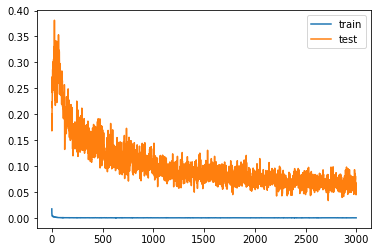

In [9]:
# 結果を読み込み
import json
with open('result/log') as f:
     logs = json.load(f)
 
# 結果を整理
loss_train = [ log['main/loss'] for log in logs ]
loss_test  = [ log['validation/main/loss'] for log in logs ]
 
# プロット
plt.plot(loss_train, label='train')
plt.plot(loss_test,  label='test')
plt.legend()
plt.show()

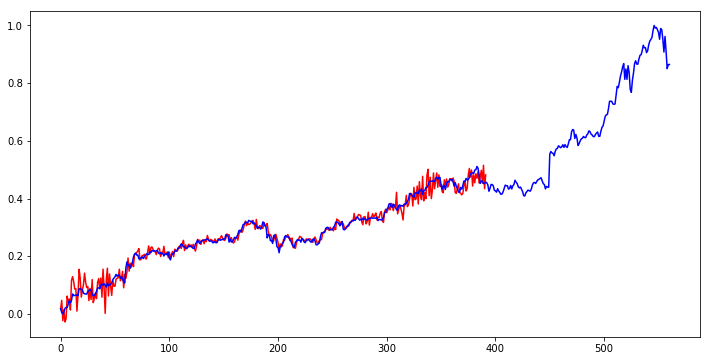

In [10]:
# 訓練：90%, 検証：10%で分割する
n_train = int(len(x) * 0.7)

train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:]

# 訓練データ
model.reset_state()
train_y = model.predict(Variable(train_x)).data# 訓練：90%, 検証：10%でランダムに分割する

n_train = int(len(x) * 1)
train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:]

# プロット
plt.figure(figsize=(12,6))
 
plt.plot(train_y, color='red')   # 予測値
plt.plot(train_t, color='blue')  # 実測値
 
plt.show()

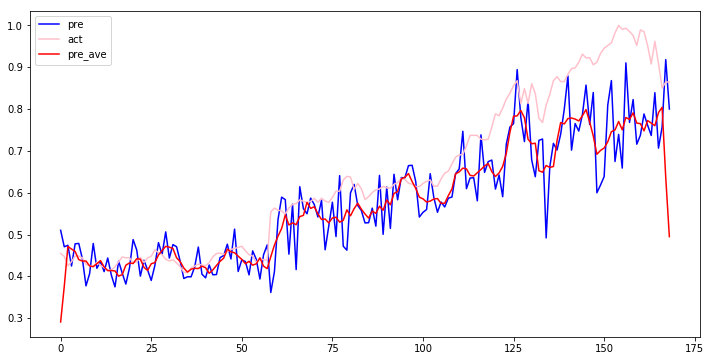

0.5476190476190477


In [14]:
n_train = int(len(x) * 0.7)
train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:]
# 検証データ
model.reset_state()
test_y = model.predict(Variable(test_x)).data
 
#予測値の移動平均を計算
num = 5
b = np.ones(num)/num
ave_test_y=np.convolve(test_y[:,0], b, mode='same')
    
# プロット
plt.figure(figsize=(12,6))
 
plt.plot(test_y,label = 'pre', color='blue')   # 予測値
plt.plot(test_t,label = 'act', color='pink')  # 実測値
plt.plot(ave_test_y,label = 'pre_ave', color='red') #移動平均予測
plt.legend()

plt.show()

updown_y = []
updown_t =[]
score = 0

for i in range(len(test_t)-1):
    if test_t[i+1]>test_t[i]:
        updown_t.append(1)
    else:
        updown_t.append(-1)
    if test_y[i+1]>test_y[i]:
        updown_y.append(1)
    else:
        updown_y.append(-1)
    
    if updown_t[i] == updown_y[i]:
        score = score + 1
    else:
        pass

score = score/len(updown_t)
print(score)